<a href="https://colab.research.google.com/github/abhilb/Open-eye-closed-eye-classification/blob/main/Part2/MRL_Eye_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, Input, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard

from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

In [2]:
tf.__version__

'2.7.0'

In [3]:
input_img = Input(shape=(32,32,1), name="input")
x = Conv2D(16, (3, 3), activation='relu', padding='same', name='conv1')(input_img)
x = MaxPooling2D((2, 2), padding='same', name='pool1')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same', name='conv2')(x)
x = MaxPooling2D((2, 2), padding='same', name='pool2')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same', name='conv3')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='encoder')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same', name='conv4')(encoded)
x = UpSampling2D((2, 2), name='upsample1')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same', name='conv5')(x)
x = UpSampling2D((2, 2), name='upsample2')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same', name='conv6')(x)
x = UpSampling2D((2, 2), name='upsample3')(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name="decoder")(x)

autoencoder = Model(input_img, decoded, name="eye_autoencoder")
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [4]:
autoencoder.summary()

Model: "eye_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 32, 1)]       0         
                                                                 
 conv1 (Conv2D)              (None, 32, 32, 16)        160       
                                                                 
 pool1 (MaxPooling2D)        (None, 16, 16, 16)        0         
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 8)         1160      
                                                                 
 pool2 (MaxPooling2D)        (None, 8, 8, 8)           0         
                                                                 
 conv3 (Conv2D)              (None, 8, 8, 8)           584       
                                                                 
 encoder (MaxPooling2D)      (None, 4, 4, 8)       

In [5]:
encoded.shape

TensorShape([None, 4, 4, 8])

In [6]:
!gdown https://drive.google.com/uc?id=1JkdFa4fj0DMrDHju7QqC4EiUfJD9Cjws

Downloading...
From: https://drive.google.com/uc?id=1JkdFa4fj0DMrDHju7QqC4EiUfJD9Cjws
To: /content/mrl_dataset.npz
100% 696M/696M [00:05<00:00, 139MB/s]


In [7]:
dataset_path = Path('mrl_dataset.npz').absolute().resolve()
data = np.load(str(dataset_path))
X = data['data']
y = data['labels']
data.close()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(f"Number of samples in training dataset: {X_train.shape[0]}")
print(f"Number of samples in testing dataset : {X_test.shape[0]}")

Number of samples in training dataset: 56881
Number of samples in testing dataset : 28017


In [9]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [10]:
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0
X_train = np.reshape(X_train, (X_train.shape[0], 32, 32, 1))
X_test = np.reshape(X_test, (X_test.shape[0], 32, 32, 1))
print(X_train.shape)
print(X_test.shape)

(56881, 32, 32, 1)
(28017, 32, 32, 1)


In [11]:
history = autoencoder.fit(X_train, X_train,
                          epochs=50,
                          batch_size=128,
                          shuffle=True,
                          validation_data=(X_test, X_test),
                          callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/50
445/445 [==============================] - 21s 21ms/step - loss: 0.0481 - val_loss: 0.0104
Epoch 2/50
445/445 [==============================] - 6s 14ms/step - loss: 0.0103 - val_loss: 0.0103
Epoch 3/50
445/445 [==============================] - 6s 15ms/step - loss: 0.0102 - val_loss: 0.0103
Epoch 4/50
445/445 [==============================] - 7s 15ms/step - loss: 0.0102 - val_loss: 0.0102
Epoch 5/50
445/445 [==============================] - 6s 14ms/step - loss: 0.0102 - val_loss: 0.0102
Epoch 6/50
445/445 [==============================] - 6s 14ms/step - loss: 0.0102 - val_loss: 0.0102
Epoch 7/50
445/445 [==============================] - 7s 15ms/step - loss: 0.0102 - val_loss: 0.0102
Epoch 8/50
445/445 [==============================] - 7s 15ms/step - loss: 0.0102 - val_loss: 0.0102
Epoch 9/50
445/445 [==============================] - 6s 15ms/step - loss: 0.0102 - val_loss: 0.0102
Epoch 10/50
445/445 [==============================] - 7s 15ms/step - loss: 0.0102 - val_l

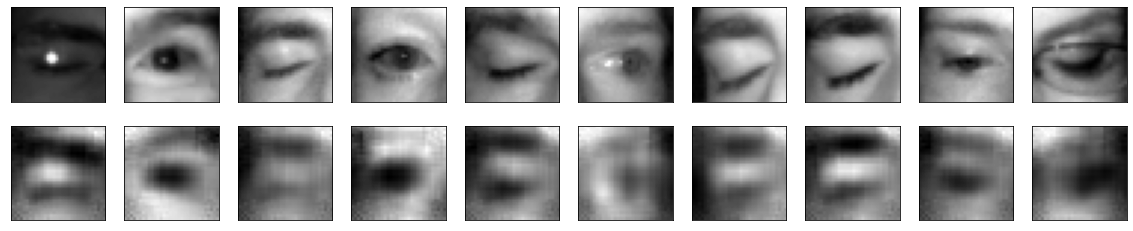

In [13]:
decoded_imgs = autoencoder.predict(X_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test[i].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()